<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/Cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **- Introduction**#

Le but de ce notebook est de réaliser de la K fold cross validation sur les différents datasets que l'on a crée dans le notebook "pre_processing.ipynb" que l'on conseille de regarder pour comprendre les comprendre. Ils seront utilisés sur les deux modèles suivants : 

1.   Un modèle RNN de convolution2D avec cellule GRU 
2.   un modèle de convolution3D







# **0 - Importation des données et librairies**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import TimeDistributed
from keras.layers import Conv3D, Conv2D,BatchNormalization,MaxPooling2D , MaxPooling3D, GlobalMaxPool2D,GlobalMaxPool3D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


Pour l'import des datasets on crée une fonction dont les paramètres sont les chemins des fichiers hdf5 que l'on souhaite utiliser pour l'apprentissage.

Les fichiers hdf5 sont générés par le notebook "pre_processing.ipynb". 
Pour faire notre choix de pré-processing, il suffit de choisir les fichiers hdf5 dont les méthodes du notebook sont indiquées dans le nom du fichier : 
"dataset_..._methode_num1_num2"

In [ ]:
def importation(path_normal, path_malade):
  hf_normal = h5py.File(path_normal, "r")
  hf_malade = h5py.File(path_malade, "r")

  # conversion des données en tableaux numpy
  Data_normal = np.array(hf_normal["dataset_1"][:])
  Data_malade = np.array(hf_malade["dataset_2"][:])

  return [Data_normal, Data_malade]

# **1 - Etude des données et création des labels**



In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.1_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.1_3.1.hdf5")

In [ ]:
Data_normal = Dataset[0]
Data_malade = Dataset[1]
Data_normal.shape, Data_malade.shape


((55720, 48, 48), (54600, 48, 48))

Afin de pouvoir utiliser des séquences dans les modèles suivant, nous modifions la shape des tableaux en créant des séquences de taille 70. 

In [ ]:
Data_normal = Data_normal.reshape(Data_normal.shape[0]//70, 70, 48, 48)
Data_malade = Data_malade.reshape(Data_malade.shape[0]//70, 70, 48, 48)
Data = np.concatenate((Data_normal, Data_malade))
Data.shape

(1576, 70, 48, 48)

Le jeu de données est composé de séquences de 70 images par scan, c'est pourquoi on attribue un label pour chaque séquence :
- 0 : La personne est négative au COVID
- 1 : La personne est positive au COVID

In [ ]:
Y_normal = np.zeros(Data_normal.shape[0], dtype=np.int8)
Y_malade = np.ones(Data_malade.shape[0], dtype=np.int8)
Y = np.concatenate((Y_normal, Y_malade))
Y.shape

(1576,)

Afin de faciliter le traitement pour la suite on encapsule la création des labels dans une fonction :

In [ ]:
def labelling(Dataset):
  Data_normal = Dataset[0]
  Data_malade = Dataset[1]
  Data_normal = Data_normal.reshape(Data_normal.shape[0]//70, 70, 48, 48)
  Data_malade = Data_malade.reshape(Data_malade.shape[0]//70, 70, 48, 48)
  Data = np.concatenate((Data_normal, Data_malade))
  Y_normal = np.zeros(Data_normal.shape[0], dtype=np.int8)
  Y_malade = np.ones(Data_malade.shape[0], dtype=np.int8)
  Y = np.concatenate((Y_normal, Y_malade))
  return Data, Y

# **2 - Modèles**




## Définition des paramètres globaux

In [ ]:
SIZE = (48, 48)
NBFRAME = 70
EPOCH = 40
BS = 8
CHANNEL = 1
INSHAPE = (70, 48, 48, 1)


On fixe la graine aléatoire afin que l'on puisse avoir des résultats similaires en relançant l'apprentissage : 

In [ ]:
def fix_seed(seed):
    tensorflow.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

On utilise le callback EarlyStop pour optimiser l'apprentissage de notre modèle.

In [ ]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor = 'val_acc',
        min_delta = 0,
        patience = 15,
        verbose = 1,
        restore_best_weights = True),
]

## Définition des modèles 



### Modèle 1 : 2DCNN + GRU

Chaque image d'entrée de la séquence doit passer dans un réseau convolutif. Le but est d'entraîner ce modèle pour chaque image et de décider ensuite de la classe à déduire.


Un ConvNet est créé et distribué en temps pour détecter les "caractéristiques".
La sortie distribuée dans le temps est injectée dans un GRU ou un LSTM pour traiter les "séries temporelles".
Un DenseNet est ensuite appliqué pour prendre la décision de "classer" si la personne a le covid ou non.




In [ ]:
# création du modèle d'apprentissage

def build_convnet2D(shape=(48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
# création du réseau de décision

def action_model2D(shape=(70, 48, 48), nbout=1):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet2D(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=(70, 48, 48,1)))
    # add the GRU cell
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

### Modèle 2 : 3DCNN




Chaque image d'entrée de la séquence doit passer dans un réseau convolutif. Le but est d'entraîner ce modèle pour **chaque séquence** ici  et de décider ensuite de la classe à déduire.

Un DenseNet est ensuite appliqué pour prendre la décision de "classer" si la personne a le covid ou non.

In [ ]:
# création du modèle d'apprentissage

def build_convnet3D(shape=(70, 48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv3D(64, (3, 3, 3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling3D())
    
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool3D())
    return model

In [ ]:
# création du réseau de décision

def action_model3D(shape=(70, 48, 48, 1), nbout=1):
    convnet = build_convnet3D(shape)
    
    model = keras.Sequential()
    model.add(convnet)
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

# **3 - CROSS VALIDATION**


## Fonctions de cross validation pour chaque modèle

In [ ]:
def KfoldValidation2D(n_splits):
  kfold = KFold(n_splits=4, shuffle=True)
  acc_per_fold = []
  loss_per_fold = []
# K-fold Cross Validation model evaluation
  fold_no = 1
  for train, validation in kfold.split(Data_train, y_train):

    model2D = action_model2D(INSHAPE, nbout=1)
    optimizer = tensorflow.keras.optimizers.Adam(0.001)
    model2D.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
  )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model2D.fit(Data_train[train], y_train[train],
              batch_size=BS,
              epochs=EPOCH,callbacks = my_callbacks, validation_data=(Data_train[validation], y_train[validation])
              )

  # Evaluation
    scores = model2D.evaluate(Data_test,y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model2D.metrics_names[0]} of {scores[0]}; {model2D.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1




# == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [ ]:
def KfoldValidation3D(n_splits):
  kfold = KFold(n_splits=4, shuffle=True)
  acc_per_fold = []
  loss_per_fold = []
# K-fold Cross Validation model evaluation
  fold_no = 1
  for train, validation in kfold.split(Data_train, y_train):

    model3D = action_model3D(INSHAPE, nbout=1)
    optimizer = tensorflow.keras.optimizers.Adam(0.001)
    model3D.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model3D.fit(Data_train[train], y_train[train],
              batch_size=BS,
              epochs=EPOCH,callbacks = my_callbacks, validation_data=(Data_train[validation], y_train[validation])
              )

  # Evaluation
    scores = model3D.evaluate(Data_test,y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model3D.metrics_names[0]} of {scores[0]}; {model3D.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1




# == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

## Modèle 1 : 2DCNN + GRU

On utilise la cross validation sur ce modèle avec toutes les différentes combinaisons possibles de pre-processing

1er pre-processing : elimination random + ajout images noires à la fin 



In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.1_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.1_3.1.hdf5")
Data, Y = labelling(Dataset)


In [ ]:
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)


In [ ]:
KfoldValidation2D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 38s 170ms/step - loss: 0.5905 - acc: 0.7375 - val_loss: 0.4899 - val_acc: 0.7859
Epoch 2/40
133/133 [==============================] - 20s 147ms/step - loss: 0.4625 - acc: 0.8006 - val_loss: 0.9968 - val_acc: 0.6225
Epoch 3/40
133/133 [==============================] - 20s 147ms/step - loss: 0.4370 - acc: 0.7968 - val_loss: 0.2473 - val_acc: 0.8930
Epoch 4/40
133/133 [==============================] - 20s 147ms/step - loss: 0.3266 - acc: 0.8664 - val_loss: 0.2542 - val_acc: 0.8817
Epoch 5/40
133/133 [==============================] - 20s 147ms/step - loss: 0.3077 - acc: 0.8833 - val_loss: 0.5497 - val_acc: 0.6676
Epoch 6/40
133/133 [==============================] - 20s 147ms/step - loss: 0.3132 - acc: 0.8815 - val_loss: 0.2510 - val_acc: 0.9070
Epoch 7/40
133/133 [==============================] - 20s 147ms/step - loss: 0.2585 - acc: 0.

2eme pre-processing : elimination SSIM + ajout images noires à partir du milieu du scan


In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.2_3.2.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.2_3.2.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation2D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 40s 282ms/step - loss: 0.6009 - acc: 0.6679 - val_loss: 0.5507 - val_acc: 0.7408
Epoch 2/40
133/133 [==============================] - 37s 277ms/step - loss: 0.4689 - acc: 0.8100 - val_loss: 0.3756 - val_acc: 0.8479
Epoch 3/40
133/133 [==============================] - 37s 276ms/step - loss: 0.3465 - acc: 0.8674 - val_loss: 0.3745 - val_acc: 0.8394
Epoch 4/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3865 - acc: 0.8570 - val_loss: 0.3139 - val_acc: 0.9239
Epoch 5/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3398 - acc: 0.8627 - val_loss: 0.2221 - val_acc: 0.9352
Epoch 6/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3139 - acc: 0.8786 - val_loss: 0.2392 - val_acc: 0.9127
Epoch 7/40
133/133 [==============================] - 37s 275ms/step - loss: 0.2595 - acc: 0.

3 eme preprocessing : random + milieu de scan

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.2_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.2_3.1.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation2D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 40s 285ms/step - loss: 0.5533 - acc: 0.7112 - val_loss: 0.4760 - val_acc: 0.8310
Epoch 2/40
133/133 [==============================] - 36s 275ms/step - loss: 0.4222 - acc: 0.8307 - val_loss: 0.3560 - val_acc: 0.8648
Epoch 3/40
133/133 [==============================] - 36s 274ms/step - loss: 0.3329 - acc: 0.8683 - val_loss: 0.2739 - val_acc: 0.8789
Epoch 4/40
133/133 [==============================] - 36s 274ms/step - loss: 0.2930 - acc: 0.8890 - val_loss: 0.2789 - val_acc: 0.9183
Epoch 5/40
133/133 [==============================] - 36s 273ms/step - loss: 0.3236 - acc: 0.8768 - val_loss: 0.1856 - val_acc: 0.9239
Epoch 6/40
133/133 [==============================] - 36s 274ms/step - loss: 0.2535 - acc: 0.8937 - val_loss: 0.2385 - val_acc: 0.9324
Epoch 7/40
133/133 [==============================] - 36s 274ms/step - loss: 0.2882 - acc: 0.

4 eme pre processing : random + debut et fin de scan

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.3_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.3_3.1.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation2D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 38s 272ms/step - loss: 0.5738 - acc: 0.6961 - val_loss: 0.6337 - val_acc: 0.5803
Epoch 2/40
133/133 [==============================] - 36s 274ms/step - loss: 0.4584 - acc: 0.7987 - val_loss: 0.3473 - val_acc: 0.8620
Epoch 3/40
133/133 [==============================] - 37s 277ms/step - loss: 0.3924 - acc: 0.8420 - val_loss: 0.3625 - val_acc: 0.8592
Epoch 4/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3279 - acc: 0.8721 - val_loss: 0.2252 - val_acc: 0.9014
Epoch 5/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3216 - acc: 0.8608 - val_loss: 0.2478 - val_acc: 0.9042
Epoch 6/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3254 - acc: 0.8683 - val_loss: 0.2910 - val_acc: 0.8789
Epoch 7/40
133/133 [==============================] - 36s 274ms/step - loss: 0.2819 - acc: 0.

5 eme preprocessing : SSIM + fin de scan

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.1_3.2.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.1_3.2.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation2D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 43s 309ms/step - loss: 0.5378 - acc: 0.7554 - val_loss: 0.5090 - val_acc: 0.7606
Epoch 2/40
133/133 [==============================] - 37s 277ms/step - loss: 0.4603 - acc: 0.7949 - val_loss: 0.4891 - val_acc: 0.7606
Epoch 3/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3844 - acc: 0.8448 - val_loss: 0.4623 - val_acc: 0.8141
Epoch 4/40
133/133 [==============================] - 37s 277ms/step - loss: 0.3737 - acc: 0.8438 - val_loss: 0.4964 - val_acc: 0.6423
Epoch 5/40
133/133 [==============================] - 37s 276ms/step - loss: 0.4764 - acc: 0.7996 - val_loss: 0.4560 - val_acc: 0.8169
Epoch 6/40
133/133 [==============================] - 37s 277ms/step - loss: 0.4050 - acc: 0.8354 - val_loss: 0.5168 - val_acc: 0.8254
Epoch 7/40
133/133 [==============================] - 37s 277ms/step - loss: 0.3607 - acc: 0.

6 eme pre processing : SSIM + debut et fin de scan

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.3_3.2.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.3_3.2.hdf5")
Data, Y = labelling(Dataset)

Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation2D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 49s 327ms/step - loss: 0.5577 - acc: 0.7197 - val_loss: 0.3946 - val_acc: 0.8451
Epoch 2/40
133/133 [==============================] - 36s 274ms/step - loss: 0.4570 - acc: 0.8175 - val_loss: 0.2540 - val_acc: 0.8873
Epoch 3/40
133/133 [==============================] - 37s 276ms/step - loss: 0.3244 - acc: 0.8617 - val_loss: 0.2344 - val_acc: 0.9183
Epoch 4/40
133/133 [==============================] - 37s 275ms/step - loss: 0.2907 - acc: 0.8881 - val_loss: 0.6557 - val_acc: 0.7690
Epoch 5/40
133/133 [==============================] - 37s 275ms/step - loss: 0.3058 - acc: 0.8833 - val_loss: 0.2095 - val_acc: 0.9099
Epoch 6/40
133/133 [==============================] - 37s 275ms/step - loss: 0.2584 - acc: 0.8852 - val_loss: 0.1934 - val_acc: 0.9211
Epoch 7/40
133/133 [==============================] - 36s 274ms/step - loss: 0.2034 - acc: 0.

## Modèle 2 : 3DCNN 

1er preprocessing : elimination aleatoire + images noires a la fin 


In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.1_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.1_3.1.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation3D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 46s 336ms/step - loss: 0.9745 - acc: 0.5268 - val_loss: 0.6701 - val_acc: 0.4676
Epoch 2/40
133/133 [==============================] - 44s 333ms/step - loss: 0.6812 - acc: 0.5682 - val_loss: 0.5355 - val_acc: 0.8704
Epoch 3/40
133/133 [==============================] - 44s 333ms/step - loss: 0.5051 - acc: 0.7705 - val_loss: 0.4812 - val_acc: 0.7380
Epoch 4/40
133/133 [==============================] - 44s 333ms/step - loss: 0.4883 - acc: 0.7893 - val_loss: 0.4231 - val_acc: 0.9070
Epoch 5/40
133/133 [==============================] - 44s 333ms/step - loss: 0.4064 - acc: 0.8269 - val_loss: 0.3385 - val_acc: 0.9155
Epoch 6/40
133/133 [==============================] - 44s 333ms/step - loss: 0.3742 - acc: 0.8438 - val_loss: 0.2402 - val_acc: 0.9155
Epoch 7/40
133/133 [==============================] - 44s 333ms/step - loss: 0.3433 - acc: 0.

2eme preprocessing : SSIM + images noires a partir du milieu du scan




In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.2_3.2.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.2_3.2.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation3D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 48s 346ms/step - loss: 1.0418 - acc: 0.5315 - val_loss: 0.6285 - val_acc: 0.5493
Epoch 2/40
133/133 [==============================] - 44s 335ms/step - loss: 0.7056 - acc: 0.5701 - val_loss: 0.7010 - val_acc: 0.5465
Epoch 3/40
133/133 [==============================] - 45s 335ms/step - loss: 0.6027 - acc: 0.6849 - val_loss: 0.4324 - val_acc: 0.8479
Epoch 4/40
133/133 [==============================] - 44s 335ms/step - loss: 0.4753 - acc: 0.8024 - val_loss: 0.4232 - val_acc: 0.7887
Epoch 5/40
133/133 [==============================] - 44s 334ms/step - loss: 0.3722 - acc: 0.8542 - val_loss: 0.4977 - val_acc: 0.7690
Epoch 6/40
133/133 [==============================] - 44s 335ms/step - loss: 0.3886 - acc: 0.8532 - val_loss: 0.4978 - val_acc: 0.8141
Epoch 7/40
133/133 [==============================] - 45s 335ms/step - loss: 0.3926 - acc: 0.

3 eme preprocessing : random + milieu de scan

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.2_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.2_3.1.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation3D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 90s 569ms/step - loss: 0.9471 - acc: 0.5155 - val_loss: 0.6515 - val_acc: 0.5408
Epoch 2/40
133/133 [==============================] - 75s 562ms/step - loss: 0.5378 - acc: 0.7328 - val_loss: 0.3146 - val_acc: 0.8704
Epoch 3/40
133/133 [==============================] - 77s 576ms/step - loss: 0.4916 - acc: 0.7723 - val_loss: 0.4774 - val_acc: 0.8056
Epoch 4/40
133/133 [==============================] - 78s 584ms/step - loss: 0.4163 - acc: 0.8373 - val_loss: 0.2913 - val_acc: 0.8704
Epoch 5/40
133/133 [==============================] - 78s 585ms/step - loss: 0.3813 - acc: 0.8476 - val_loss: 0.2502 - val_acc: 0.8930
Epoch 6/40
133/133 [==============================] - 78s 588ms/step - loss: 0.3961 - acc: 0.8260 - val_loss: 0.2772 - val_acc: 0.8958
Epoch 7/40
133/133 [==============================] - 78s 590ms/step - loss: 0.3690 - acc: 0.

4 eme pre processing : random + debut et fin de scan


In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.3_3.1.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.3_3.1.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation3D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 78s 581ms/step - loss: 1.0877 - acc: 0.5221 - val_loss: 0.7158 - val_acc: 0.4901
Epoch 2/40
133/133 [==============================] - 76s 572ms/step - loss: 0.7604 - acc: 0.4929 - val_loss: 0.6962 - val_acc: 0.4901
Epoch 3/40
133/133 [==============================] - 76s 571ms/step - loss: 0.7347 - acc: 0.5118 - val_loss: 0.6906 - val_acc: 0.5099
Epoch 4/40
133/133 [==============================] - 75s 565ms/step - loss: 0.6177 - acc: 0.6576 - val_loss: 0.3137 - val_acc: 0.8817
Epoch 5/40
133/133 [==============================] - 75s 566ms/step - loss: 0.6045 - acc: 0.7159 - val_loss: 0.4080 - val_acc: 0.8141
Epoch 6/40
133/133 [==============================] - 75s 568ms/step - loss: 0.4602 - acc: 0.8015 - val_loss: 0.3910 - val_acc: 0.8451
Epoch 7/40
133/133 [==============================] - 75s 567ms/step - loss: 0.3993 - acc: 0.

5 eme preprocessing : SSIM + fin de scan


In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.1_3.2.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.1_3.2.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation3D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 82s 608ms/step - loss: 1.0676 - acc: 0.5136 - val_loss: 0.6102 - val_acc: 0.8056
Epoch 2/40
133/133 [==============================] - 76s 572ms/step - loss: 0.7436 - acc: 0.5390 - val_loss: 0.6172 - val_acc: 0.5352
Epoch 3/40
133/133 [==============================] - 76s 571ms/step - loss: 0.6514 - acc: 0.6284 - val_loss: 0.3322 - val_acc: 0.8704
Epoch 4/40
133/133 [==============================] - 76s 571ms/step - loss: 0.5534 - acc: 0.7592 - val_loss: 0.3089 - val_acc: 0.8732
Epoch 5/40
133/133 [==============================] - 76s 569ms/step - loss: 0.4178 - acc: 0.8363 - val_loss: 0.3345 - val_acc: 0.8732
Epoch 6/40
133/133 [==============================] - 76s 570ms/step - loss: 0.3481 - acc: 0.8692 - val_loss: 0.2784 - val_acc: 0.8930
Epoch 7/40
133/133 [==============================] - 76s 569ms/step - loss: 0.3586 - acc: 0.

6 eme pre processing : SSIM + debut et fin de scan

In [ ]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.3_3.2.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.3_3.2.hdf5")
Data, Y = labelling(Dataset)
Data_train, Data_test, y_train, y_test = train_test_split(Data, Y, test_size=0.1, random_state=42)

In [ ]:
KfoldValidation3D(4)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 78s 579ms/step - loss: 1.0086 - acc: 0.5381 - val_loss: 0.6627 - val_acc: 0.5437
Epoch 2/40
133/133 [==============================] - 76s 570ms/step - loss: 0.6500 - acc: 0.6030 - val_loss: 1.6255 - val_acc: 0.5944
Epoch 3/40
133/133 [==============================] - 76s 569ms/step - loss: 0.7630 - acc: 0.5494 - val_loss: 0.3970 - val_acc: 0.8366
Epoch 4/40
133/133 [==============================] - 76s 569ms/step - loss: 0.5171 - acc: 0.7752 - val_loss: 0.3167 - val_acc: 0.8704
Epoch 5/40
133/133 [==============================] - 75s 568ms/step - loss: 0.4654 - acc: 0.8184 - val_loss: 0.4186 - val_acc: 0.8507
Epoch 6/40
133/133 [==============================] - 76s 568ms/step - loss: 0.3973 - acc: 0.8438 - val_loss: 0.2941 - val_acc: 0.8704
Epoch 7/40
133/133 [==============================] - 75s 568ms/step - loss: 0.3466 - acc: 0.

# **4 - BILAN**

On peut dresser un bilan de la cross validation appliquée aux différents pre-processing et modèles :


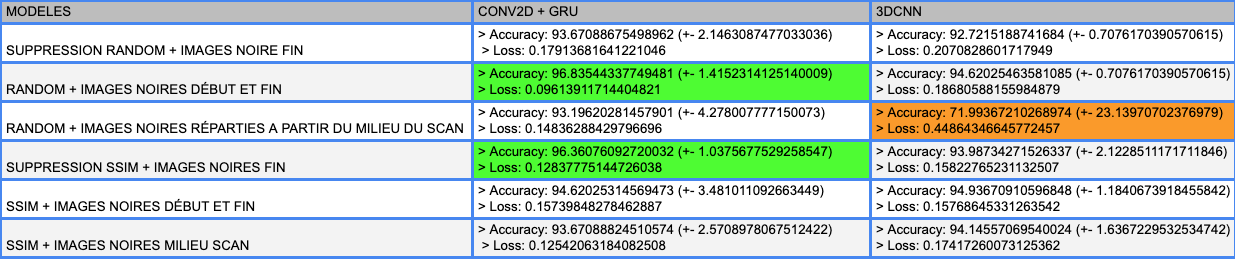

On en conclut que le modèle de convolution 2D + cellule GRU nous permet d'obtenir une accuracy moyenne supérieure à 96% avec les preprocessing : 


*   Suppression d'images aléatoire pour les scans qui contenaient plus de 70 images et ajout d'images noires en début et fin de séquences pours les scans contenant moins de 70 images. 
*   Suppression d'images par comparaison SSIM pour les scans qui contenaient plus de 70 images et ajout d'images noires à la fin de la séquence pour les scans contenant moins de 70 images. 



